<a href="https://colab.research.google.com/github/ufrpe-bcc-ia/projetos-hyan/blob/main/notebooks/texas_distilbert_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
%%capture
from google.colab import drive
drive.mount('/content/drive');

In [46]:
DATASET = '/content/drive/MyDrive/Research/Projeto Correção de questão/Data/TexasDataset/EXCEL/texas_dataset.xlsx'
TARGET = 'input'
TEST_SIZE = 0.2
SEED = 42

In [47]:
%%capture
!pip install datasets

In [48]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import warnings
import joblib
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModel
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from tqdm.notebook import tqdm_notebook

In [49]:
warnings.filterwarnings("ignore")

In [50]:
sns.set_theme(style='darkgrid')
tqdm_notebook.pandas()

In [51]:
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(SEED)

# Data Analysis

In [52]:
columns_dict = {
  "Topic": "topic",
  "Human Evaluation": "human_evaluation",
  "Round_score": "human_evaluation",
  "Question": "question",
  "Student Answer": "answer",
  "Question_ID": "question_id",
  "Score": "score"
}

In [53]:
dataset = pd.read_excel(DATASET)
dataset.rename(columns=columns_dict, inplace=True)
dataset.head()

,ID,question_id,question,Instructor answers,answer,score,human_evaluation
0,1,2023-01-01,What is the role of a prototype program in pr...,To simulate the behaviour of portions of the ...,High risk problems are address in the prototy...,3.5,4
1,2,2023-01-01,What is the role of a prototype program in pr...,To simulate the behaviour of portions of the ...,To simulate portions of the desired final pro...,5.0,5
2,3,2023-01-01,What is the role of a prototype program in pr...,To simulate the behaviour of portions of the ...,A prototype program simulates the behaviors o...,4.0,4
3,4,2023-01-01,What is the role of a prototype program in pr...,To simulate the behaviour of portions of the ...,Defined in the Specification phase a prototyp...,5.0,5
4,5,2023-01-01,What is the role of a prototype program in pr...,To simulate the behaviour of portions of the ...,It is used to let the users have a first idea...,3.0,3


## Data split

In [54]:
X = dataset.drop("human_evaluation", axis=1)
y = dataset["human_evaluation"]

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=dataset["human_evaluation"], shuffle=True, random_state=SEED)
len(X_train), len(X_test), len(y_train), len(y_test)

(1953, 489, 1953, 489)

## Training set

### Solving the unbalanced data problem

In [56]:
train_set = pd.concat([X_train, y_train], axis=1)
train_set.head()

,ID,question_id,question,Instructor answers,answer,score,human_evaluation
962,963,2023-01-06,What is a pointer?,A variable that contains the address in memory...,It is like a variable however instead of holdi...,4.5,5
2194,2195,2023-02-12,What is the experimental approach for measurin...,Implement the algorithm and measure the physic...,Experimental means you would actually write a ...,5.0,5
46,47,2023-02-01,What stages in the software life cycle are in...,The testing stage can influence both the codi...,"Depending on how the work is done, Testing is...",1.5,2
1426,1427,2023-05-08,Which implementation (array-based vs. list-bas...,"Link-based, because they are dynamic (no size ...",Array-based prevents the push operation from ...,5.0,5
2441,2442,2023-10-12,How many steps does it take to search a node i...,The height of the tree.,it depends on the install search tree then fro...,1.5,2


In [57]:
label_5_ds = train_set[train_set["human_evaluation"] == 5]
label_5_ds = pd.concat([label_5_ds] * 1, axis=0, ignore_index=True)

label_4_ds = train_set[train_set["human_evaluation"] == 4]
label_4_ds = pd.concat([label_4_ds] * 4, axis=0, ignore_index=True)

label_3_ds = train_set[train_set["human_evaluation"] == 3]
label_3_ds = pd.concat([label_3_ds] * 5, axis=0, ignore_index=True)

label_2_ds = train_set[train_set["human_evaluation"] == 2]
label_2_ds = pd.concat([label_2_ds] * 10, axis=0, ignore_index=True)

label_1_ds = train_set[train_set["human_evaluation"] == 1]
label_1_ds = pd.concat([label_1_ds] * 50, axis=0, ignore_index=True)

label_0_ds = train_set[train_set["human_evaluation"] == 0]
label_0_ds = pd.concat([label_0_ds] * 53, axis=0, ignore_index=True)

train_set = pd.concat([label_0_ds, label_1_ds, label_2_ds, label_3_ds, label_4_ds, label_5_ds], axis=0)
len(train_set)

6902

In [58]:
train_set = train_set.sample(frac=1, random_state=SEED).reset_index(drop=True)
train_set.head()

,ID,question_id,question,Instructor answers,answer,score,human_evaluation
0,1223,2023-04-07,How are linked lists passed as arguments to a ...,By reference.,not answered,0.0,0
1,1777,2023-04-10,What is a binary tree?,A tree for which the maximum number of childre...,A binary search tree is a tree that also has t...,4.5,5
2,2240,2023-03-12,Order the following functions by their running...,log(log n); 2^(log n) ; n^2 ; n^3; n!,longest to shortest:<br>n^3; n!; n^2; 2^(log n...,3.0,3
3,690,2023-02-04,What is the main difference between strings de...,The strings declared using an array of charact...,array it is the collection of similar data ty...,2.5,3
4,2422,2023-10-12,How many steps does it take to search a node i...,The height of the tree.,2^n where n is the # of levels the binary tree...,2.0,2


In [59]:
train_set['answer'] = train_set['answer'].astype(str)
train_set['question'] = train_set['question'].astype(str)
train_set['question_id'] = train_set['question_id'].astype(str)
train_set.drop("score", inplace=True, axis=1)

In [60]:
train_set.dropna(inplace=True)
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6902 entries, 0 to 6901
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  6902 non-null   int64 
 1   question_id         6902 non-null   object
 2   question            6902 non-null   object
 3   Instructor answers  6902 non-null   object
 4   answer              6902 non-null   object
 5   human_evaluation    6902 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 323.7+ KB


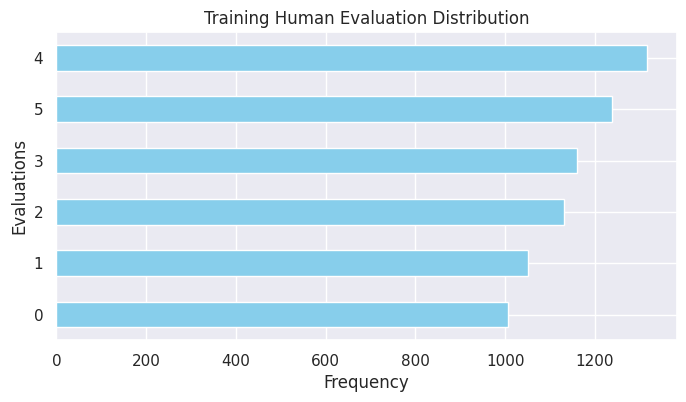

In [61]:
plt.figure(figsize=(8, 4))
train_set['human_evaluation'].value_counts(ascending=True).plot.barh(color='skyblue')
plt.title('Training Human Evaluation Distribution')
plt.xlabel('Frequency')
plt.ylabel('Evaluations')
plt.show()

## Testing Set

In [62]:
test_set = pd.concat([X_test, y_test], axis=1)
test_set.head()

,ID,question_id,question,Instructor answers,answer,score,human_evaluation
1111,1112,2023-07-06,What is a function pointer?,The address of the location in memory where th...,A pointer to a function is the address where t...,5.0,5
1038,1039,2023-04-06,How can an array be addressed in pointer/offse...,By initializing a pointer to point to the firs...,Element b[ n ] can be accessed by *( bPtr + n...,4.5,5
11,12,2023-01-01,What is the role of a prototype program in pr...,To simulate the behaviour of portions of the ...,A program that simulates the behavior of port...,5.0,5
1724,1725,2023-02-10,What is the height of a tree?,The length of the longest path from the root t...,The height is the number of generations (level...,4.5,5
1476,1477,2023-06-08,How are infix expressions evaluated by computers?,"First, they are converted into postfix form, f...",they are transformed into post-fix expressions...,5.0,5


In [63]:
test_set['answer'] = test_set['answer'].astype(str)
test_set['question'] = test_set['question'].astype(str)
test_set['question_id'] = test_set['question_id'].astype(str)
test_set.drop('score', inplace=True, axis=1)

In [64]:
test_set.dropna(inplace=True)
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489 entries, 1111 to 44
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  489 non-null    int64 
 1   question_id         489 non-null    object
 2   question            489 non-null    object
 3   Instructor answers  489 non-null    object
 4   answer              489 non-null    object
 5   human_evaluation    489 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 26.7+ KB


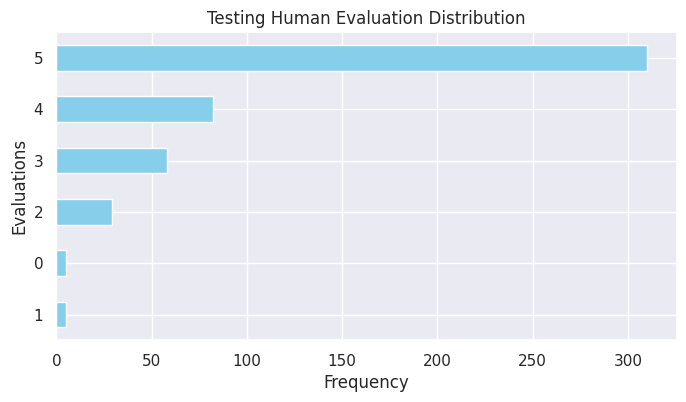

In [65]:
plt.figure(figsize=(8, 4))
test_set['human_evaluation'].value_counts(ascending=True).plot.barh(color='skyblue')
plt.title('Testing Human Evaluation Distribution')
plt.xlabel('Frequency')
plt.ylabel('Evaluations')
plt.show()

## All dataset

In [66]:
dataset = pd.concat([train_set, test_set])
dataset.head()

,ID,question_id,question,Instructor answers,answer,human_evaluation
0,1223,2023-04-07,How are linked lists passed as arguments to a ...,By reference.,not answered,0
1,1777,2023-04-10,What is a binary tree?,A tree for which the maximum number of childre...,A binary search tree is a tree that also has t...,5
2,2240,2023-03-12,Order the following functions by their running...,log(log n); 2^(log n) ; n^2 ; n^3; n!,longest to shortest:<br>n^3; n!; n^2; 2^(log n...,3
3,690,2023-02-04,What is the main difference between strings de...,The strings declared using an array of charact...,array it is the collection of similar data ty...,3
4,2422,2023-10-12,How many steps does it take to search a node i...,The height of the tree.,2^n where n is the # of levels the binary tree...,2


In [67]:
dataset['answer'] = dataset['answer'].astype(str)
dataset['question'] = dataset['question'].astype(str)

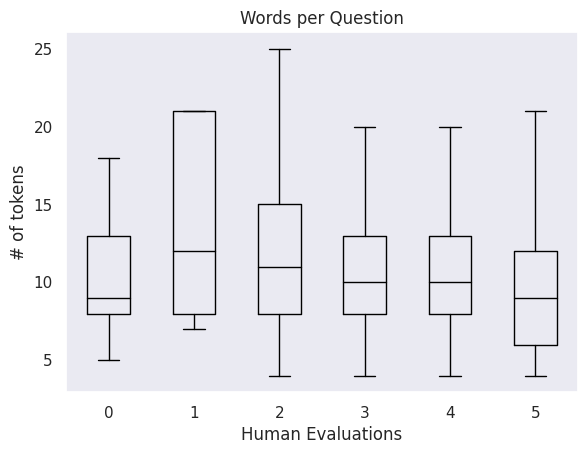

In [68]:
dataset['words_per_question'] = dataset['question'].str.split().apply(len)
dataset.boxplot('words_per_question', by='human_evaluation', grid=False, color='black', showfliers=False)
plt.title('Words per Question')
plt.suptitle('')
plt.xlabel('Human Evaluations')
plt.ylabel('# of tokens')
plt.show()

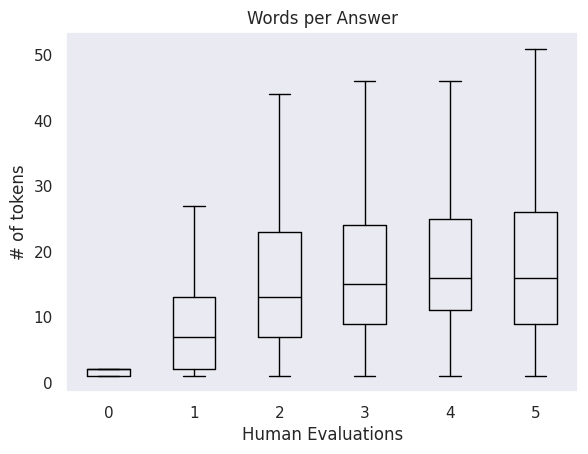

In [69]:
dataset['words_per_answer'] = dataset['answer'].str.split().apply(len)
dataset.boxplot('words_per_answer', by='human_evaluation', grid=False, color='black', showfliers=False)
plt.title('Words per Answer')
plt.suptitle('')
plt.xlabel('Human Evaluations')
plt.ylabel('# of tokens')
plt.show()

# Training

In [70]:
if TARGET != 'answer':
    train_set['input'] = train_set.progress_apply(lambda row: row['question'] + ' ' + row['answer'], axis=1)
    test_set['input'] = test_set.progress_apply(lambda row: row['question'] + ' ' + row['answer'], axis=1)

display(train_set.head(2))
display(test_set.head(2))

  0%|          | 0/6902 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

,ID,question_id,question,Instructor answers,answer,human_evaluation,input
0,1223,2023-04-07,How are linked lists passed as arguments to a ...,By reference.,not answered,0,How are linked lists passed as arguments to a ...
1,1777,2023-04-10,What is a binary tree?,A tree for which the maximum number of childre...,A binary search tree is a tree that also has t...,5,What is a binary tree? A binary search tree is...


,ID,question_id,question,Instructor answers,answer,human_evaluation,input
1111,1112,2023-07-06,What is a function pointer?,The address of the location in memory where th...,A pointer to a function is the address where t...,5,What is a function pointer? A pointer to a fun...
1038,1039,2023-04-06,How can an array be addressed in pointer/offse...,By initializing a pointer to point to the firs...,Element b[ n ] can be accessed by *( bPtr + n...,5,How can an array be addressed in pointer/offse...


## Data Pre-processing

In [71]:
# Load the dataset
train_ds = Dataset.from_pandas(train_set, split='train')
test_ds = Dataset.from_pandas(test_set, split='test')
ds = DatasetDict()
ds['train'] = train_ds
ds['test'] = test_ds

In [72]:
# Load the tokenizer
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [73]:
# Tokenizing a question
target = TARGET

ds.set_format(type='pandas')
text = ds['train'][:][target].iloc[0]
ds.reset_format()
encoded_text = tokenizer(text)
tokens = tokenizer.convert_ids_to_tokens(encoded_text['input_ids'])
tokenizer.convert_tokens_to_string(tokens)

'[CLS] how are linked lists passed as arguments to a function? not answered [SEP]'

In [74]:
# Model maximum context size and vocabulary size

tokenizer.model_max_length, tokenizer.vocab_size

(512, 30522)

In [75]:
def tokenize(tokenizer: AutoTokenizer, batch, target):
    return tokenizer(batch[target], padding=True, truncation=True)

In [76]:
target = TARGET
ds_encoded = ds.map(lambda batch: tokenize(tokenizer, batch, target), batched=True, batch_size=None)

Map:   0%|          | 0/6902 [00:00<?, ? examples/s]

Map:   0%|          | 0/489 [00:00<?, ? examples/s]

In [77]:
ds_encoded['train'].column_names

['ID',
 'question_id',
 'question',
 'Instructor answers',
 'answer',
 'human_evaluation',
 'input',
 'input_ids',
 'attention_mask']

### BERT + classifier

In [78]:
model_ckpt = 'distilbert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [79]:
def extract_hidden_states(tokenizer: AutoTokenizer, model: AutoModel, batch, device):
    inputs = {
        k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names
    }
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [80]:
target = TARGET
ds_encoded.set_format('torch', columns=['input_ids', 'attention_mask', target])
ds_hidden = ds_encoded.map(lambda batch: extract_hidden_states(tokenizer, model, batch, device), batched=True)
ds_hidden['train'].column_names

Map:   0%|          | 0/6902 [00:00<?, ? examples/s]

Map:   0%|          | 0/489 [00:00<?, ? examples/s]

['ID',
 'question_id',
 'question',
 'Instructor answers',
 'answer',
 'human_evaluation',
 'input',
 'input_ids',
 'attention_mask',
 'hidden_state']

In [81]:
X_train = np.array(ds_hidden['train']['hidden_state'])
y_train = np.array(ds_hidden['train']['human_evaluation'])
X_test = np.array(ds_hidden['test']['hidden_state'])
y_test = np.array(ds_hidden['test']['human_evaluation'])
X_train.shape, y_train.shape

((6902, 768), (6902,))

#### Decision Tree Classifier

In [82]:
dtc = DecisionTreeClassifier(random_state=SEED)

dtc.fit(X_train, y_train)
dtc_y_pred = dtc.predict(X_test)
report = classification_report(y_test, dtc_y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.29      0.40      0.33         5
           2       0.12      0.07      0.09        29
           3       0.19      0.21      0.20        58
           4       0.29      0.33      0.31        82
           5       0.72      0.71      0.72       310

    accuracy                           0.55       489
   macro avg       0.41      0.45      0.43       489
weighted avg       0.55      0.55      0.55       489



#### Random Forest Classification

In [83]:
rfc = RandomForestClassifier(n_estimators=400, random_state=SEED)

rfc.fit(X_train, y_train)
rfc_y_pred = dtc.predict(X_test)
report = classification_report(y_test, rfc_y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.29      0.40      0.33         5
           2       0.12      0.07      0.09        29
           3       0.19      0.21      0.20        58
           4       0.29      0.33      0.31        82
           5       0.72      0.71      0.72       310

    accuracy                           0.55       489
   macro avg       0.41      0.45      0.43       489
weighted avg       0.55      0.55      0.55       489



#### Support Vector Classifier

In [84]:
svc = OneVsRestClassifier(
    SVR(
        kernel="rbf",
        gamma=0.1,
        coef0=0.0,
        C=1.0,
    )
)

svc.fit(X_train, y_train)
svc_y_pred = svc.predict(X_test)
report = classification_report(y_test, svc_y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.50      0.40      0.44         5
           2       0.43      0.21      0.28        29
           3       0.44      0.28      0.34        58
           4       0.35      0.34      0.35        82
           5       0.78      0.88      0.83       310

    accuracy                           0.67       489
   macro avg       0.58      0.52      0.54       489
weighted avg       0.65      0.67      0.65       489



#### XGB Classifier

In [85]:
xgbc = XGBClassifier(random_state=SEED)
xgbc.fit(X_train, y_train)
xgbc_y_pred = xgbc.predict(X_test)
report = classification_report(y_test, xgbc_y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.67      0.40      0.50         5
           2       0.20      0.03      0.06        29
           3       0.48      0.17      0.25        58
           4       0.40      0.30      0.35        82
           5       0.72      0.92      0.81       310

    accuracy                           0.67       489
   macro avg       0.58      0.47      0.49       489
weighted avg       0.61      0.67      0.62       489



### Model Evaluation

In [86]:
tfidf_svm_ovr_kappa = cohen_kappa_score(y_test, svc_y_pred)
tfidf_rf_kappa = cohen_kappa_score(y_test, rfc_y_pred)
tfidf_tree_kappa = cohen_kappa_score(y_test, dtc_y_pred)
tfidf_xgb_kappa = cohen_kappa_score(y_test, xgbc_y_pred)

In [87]:
kappas = {
    "distilbert_svm_ovr_kappa": distilbert_svm_ovr_kappa,
    "distilbert_rf_kappa": distilbert_rf_kappa,
    "distilbert_tree_kappa": distilbert_tree_kappa,
    "distilbert_xgb_kappa": distilbert_xgb_kappa
}

kappas_df = pd.DataFrame(data=[kappas]).T.reset_index()
kappas_df.columns = ["Metric", "Score"]
kappas_df

,Metric,Score
0,tfidf_svm_ovr_kappa,0.358987
1,tfidf_rf_kappa,0.188068
2,tfidf_tree_kappa,0.188068
3,tfidf_xgb_kappa,0.285062


In [88]:
joblib.dump(svc, "svm_ovr_model.pkl")

['svm_ovr_model.pkl']